## Imports Iniciais


In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import os
import fsp as fsp




data = sio.loadmat('Datasets/mvnrnd01.mat')
X = data['X']
XTest = X[:315, :]
XTest2 = X[385:, :]
XTrain = X[315:385, :]
#juntar os dois conjuntos de teste
XTest = np.concatenate((XTest, XTest2), axis=0)
y = data['y']
yTest = y[:315, :]
yTest2 = y[385:, :]
yTrain = y[315:385, :]
#juntar os dois conjuntos de teste
yTest = np.concatenate((yTest, yTest2), axis=0)
opt = {
    'initial_k': 1,
    'p_parameter': 0.05,
    'h_threshold': 0,
    'dm_case': 2,
    'dm_threshold': 0.5,
    'update_dm_threshold': True,
    'return_full_dm': False,
    'return_full_history': True,
    'iteration_threshold': 2e6,
    'rng_default': False,
    'PD_case': 2,
    'NumberOfRuns': 10,
    'KFold': 10,
    'knn_NumNeighbors': int(np.floor(np.sqrt(len(data['y']))))
}
rmH, H = fsp.Feature_Space_Partition(X, y, opt)
print('rmH = ', rmH)

C_list = []
for i in range(len(H)):
    C_list.append(H[i]['C'])


dm_case = 1
datasetfilename = 'mvnrnd01.mat'

rmH =  [{'i': [2], 'k': [2], 'C': [array([[-2.95937576, -0.00904223],
       [ 3.27010143,  0.23296858]])], 'rmCidx': [array([1])], 'rmC': [array([[3.27010143, 0.23296858]])], 'dm_threshold': [0.5], 'dm': [array([], dtype=float64)], 'rmDominantClassLabel': [array([1.])], 'rmDominantClassLabel_Proportion': [array([0.96904025])], 'sum1': [0.4471428571428571], 'rmXidx': [array([  6,   7,   9,  67,  91, 118, 161, 254, 256, 334, 350, 351, 352,
       353, 354, 355, 357, 359, 360, 361, 363, 364, 365, 366, 367, 368,
       369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 382,
       384, 385, 386, 387, 388, 389, 391, 393, 394, 395, 396, 398, 399,
       400, 401, 402, 403, 404, 405, 408, 409, 410, 411, 412, 413, 414,
       415, 416, 417, 418, 419, 420, 421, 422, 424, 425, 426, 427, 428,
       429, 430, 432, 433, 434, 435, 436, 437, 439, 440, 441, 442, 443,
       444, 446, 447, 448, 450, 451, 452, 453, 454, 455, 456, 457, 458,
       460, 461, 462, 463, 464, 465, 466, 467, 468, 4

## Funções de Plot

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.animation import FuncAnimation

def plot_space_segmentation_process(X, y, H, dm_case, datasetfilename):
    # Compute axis limits
    axis_limits = [np.min(X[:, 0]), np.max(X[:, 0]), np.min(X[:, 1]), np.max(X[:, 1])]
    # Create a tiled chart layout
    fig = plt.figure()
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    pp = PdfPages('multipage.pdf')

    # Loop through the segmentation process
    for i in range(len(H)):
        ax = fig.add_subplot(1, len(H), i+1)
        print("Printando o H[i][C] atual", H[i]['C'])
        _,pp = plot_segmentation(X, y, H[i]['C'], axis_limits,2,pp)
        ax.grid(False)
        ax.set_axis_off()

        # Remove data points of the i-th iteration
        rmidx = H[i]['rmXidx']
        if rmidx.size > 0:
            X = np.delete(X, rmidx, axis=0)
            y = np.delete(y, rmidx)

    # Save the figure with a transparent background
    pp.close()

In [3]:
def plot_segmentation(X, y, centroids=None, axis_limits=None, scatter_plot=2, pp = None, titulo = None):
    # Define colors for each class
    yNew = np.zeros(y.shape)
    yNew[y == 1] = int(1)
    yNew[y == 2] = int(2)
    y = np.copy(yNew)
    #print(yNew)
    y_max = np.max(y)
    
    colors = plt.cm.Set1(np.linspace(0, 1, int(y_max)))

    # Set marker size based on class for each observation coordinate
    if y_max == 2:
        sz = [1, 3]  # An empty array specifies the default size of 36 points.
    else:
        sz = np.arange(1, int(y_max) + 1)
    print(axis_limits)
    # Set axis limits
    if axis_limits is None:
        axis_limits = [np.min(X[:, 0]), np.max(X[:, 0]), np.min(X[:, 1]), np.max(X[:, 1])]
    

    # Set the scatterPlot default option
    if scatter_plot is None:
        scatter_plot = 2

    y = y.astype(int)
    sizes = np.vectorize(lambda val: sz[int(val-1)])(y)
    colors_list = np.take(colors, y-1, mode='clip')
    
    # Create a new figure and an ax object
    fig, ax = plt.subplots()
    ax.set_xlim(axis_limits[0:2])
    ax.set_xbound(axis_limits[0:2])
    ax.set_ylim(axis_limits[2:4])
    ax.set_ybound(axis_limits[2:4])
    

    # Plot the observations with class-specific colors
    if scatter_plot == 1:
        ax.scatter(X[:, 0], X[:, 1], c=colors_list, marker='o', linewidths=1, edgecolors='black')
        ax.set_xlim(axis_limits[0:2])
        ax.set_xbound(axis_limits[0:2])
        ax.set_ylim(axis_limits[2:4])
        ax.set_ybound(axis_limits[2:4])
    elif scatter_plot == 2:
        ax.scatter(X[:, 0], X[:, 1], s=sizes, c=colors_list, linewidths=1)
        ax.set_xlim(axis_limits[0:2])
        ax.set_xbound(axis_limits[0:2])
        ax.set_ylim(axis_limits[2:4])
        ax.set_ybound(axis_limits[2:4])

    #ax.axis('equal')
    ax.set_box_aspect(1)
    ax.grid(False)

    if centroids is not None:
        # Plot the centroids of each cluster
        ax.plot(centroids[:, 0], centroids[:, 1], 'kx', markersize=7, linewidth=10, color = 'red')
        ax.set_xlim(axis_limits[0:2])
        ax.set_xbound(axis_limits[0:2])
        ax.set_ylim(axis_limits[2:4])
        ax.set_ybound(axis_limits[2:4])

        # Plot edges
        if centroids.shape[0] > 2:
            # Calculate the x and y coordinates of Voronoi edges and represent them as column vectors
            vor = Voronoi(centroids)
            #print(ax.axis())
            voronoi_plot_2d(vor, show_vertices=False, line_colors='k', line_width=1, ax=ax, show_points=False)
            ax.set_xlim(axis_limits[0:2])
            ax.set_xbound(axis_limits[0:2])
            ax.set_ylim(axis_limits[2:4])
            ax.set_ybound(axis_limits[2:4])
        elif centroids.shape[0] == 2:
            # Calculate the slope of the line connecting the two centroids
            dy = centroids[1, 1] - centroids[0, 1]
            dx = centroids[1, 0] - centroids[0, 0]
            if dx == 0:
                slope_perpendicular = 0
            else:
                slope = dy / dx
                # Calculate the slope of the line perpendicular to the line connecting the two centroids
                slope_perpendicular = -1 / slope

            # Calculate the midpoint between the two centroids
            mx, my = np.mean(centroids, axis=0)
            
            # Compute two points on the perpendicular line for plotting
            # i want to my delta_x cross the hole plot
            delta_x = (axis_limits[1] - axis_limits[0]) / 2
            x1 = mx - delta_x
            y1 = my - slope_perpendicular * delta_x
            x2 = mx + delta_x
            y2 = my + slope_perpendicular * delta_x
                
            ax.plot([x1, x2], [y1, y2], '-k', linewidth=1)
            ax.set_xlim(axis_limits[0:2])
            ax.set_xbound(axis_limits[0:2])
            ax.set_ylim(axis_limits[2:4])
            ax.set_ybound(axis_limits[2:4])
        
        

    print("axis_limits", axis_limits)
    if titulo is not None:
        plt.title(titulo)
    plt.show()
    if pp is not None:
        pp.savefig(fig)

    return axis_limits, pp

In [4]:
print(C_list)



[array([[-0.084917  ,  0.10262847]]), array([[-2.95937576, -0.00904223],
       [ 3.27010143,  0.23296858]]), array([[-2.95937576, -0.00904223]]), array([[-2.96731539, -1.79672167],
       [-2.95257036,  1.52325443]]), array([[-3.84446605, -2.19012639],
       [-1.32374015,  0.03302983],
       [-3.79912761,  1.84971011]]), array([[-1.32374015,  0.03302983]]), array([[-1.14128988,  1.2284547 ],
       [-1.44537367, -0.76392008]]), array([[-1.97145399, -0.14985107],
       [-0.55012836, -1.50336775],
       [-0.92305508,  1.38738065]]), array([[-0.6835287 , -2.0653274 ],
       [-1.09989331,  1.67550891],
       [-2.27422388, -0.18560542],
       [-0.73406273, -0.06552557]]), array([[-0.85396084,  0.14109093]])]


In [5]:
C_list = []
for i in range(len(rmH)):
    rmC = rmH[i]['rmC']
    if isinstance(rmC, list):
        rmC = rmC[0]
    C_list.append(np.array(rmC))

outputRMC = np.vstack(C_list)



In [6]:
print(outputRMC)

[[ 3.27010143  0.23296858]
 [-3.84446605 -2.19012639]
 [-3.79912761  1.84971011]
 [-2.27422388 -0.18560542]
 [-0.85396084  0.14109093]]


In [7]:
def final_plot(X, y, outputRMC, axis_limits=None, scatter_plot=2, pp = None):
    # Compute axis limits
    axis_limits = [np.min(X[:, 0]), np.max(X[:, 0]), np.min(X[:, 1]), np.max(X[:, 1])]
    # Create a tiled chart layout
    fig = plt.figure()
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    pp = PdfPages('finalplot.pdf')
    _, pp = plot_segmentation(X, y, outputRMC, axis_limits,2,pp, titulo = f'Partição Final DM = { dm_case }')
    pp.close()




## Segmentação final e geração do GIF


[-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]
axis_limits [-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]


/var/folders/pt/kgrnh2rn0s39sn57_bb5hggw0000gn/T/ipykernel_6096/3935895806.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kx" (-> color='k'). The keyword argument will take precedence.
  ax.plot(centroids[:, 0], centroids[:, 1], 'kx', markersize=7, linewidth=10, color = 'red')


<Figure size 640x480 with 0 Axes>

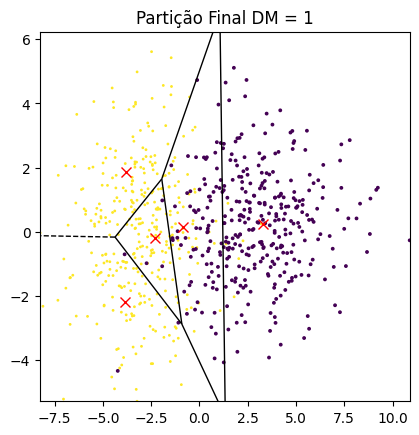

In [8]:
final_plot(X,y, outputRMC, axis_limits=None, scatter_plot=2, pp = None)

Printando o H[i][C] atual [[-0.084917    0.10262847]]
[-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]
axis_limits [-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]


/var/folders/pt/kgrnh2rn0s39sn57_bb5hggw0000gn/T/ipykernel_6096/3935895806.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "kx" (-> color='k'). The keyword argument will take precedence.
  ax.plot(centroids[:, 0], centroids[:, 1], 'kx', markersize=7, linewidth=10, color = 'red')


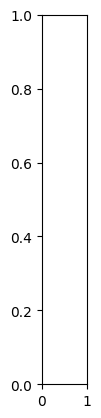

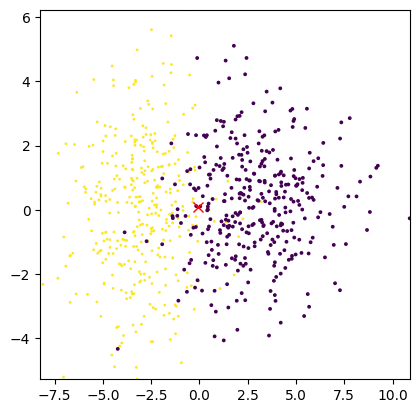

Printando o H[i][C] atual [[-2.95937576 -0.00904223]
 [ 3.27010143  0.23296858]]
[-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]
axis_limits [-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]


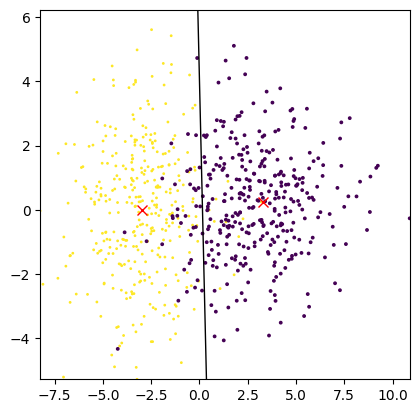

Printando o H[i][C] atual [[-2.95937576 -0.00904223]]
[-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]
axis_limits [-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]


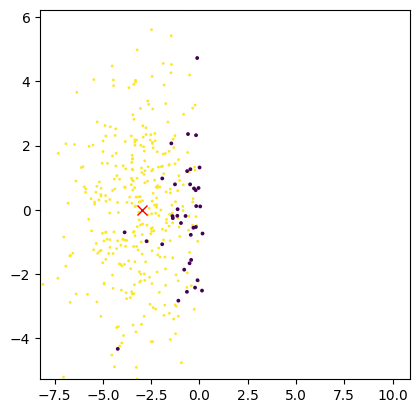

Printando o H[i][C] atual [[-2.96731539 -1.79672167]
 [-2.95257036  1.52325443]]
[-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]
axis_limits [-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]


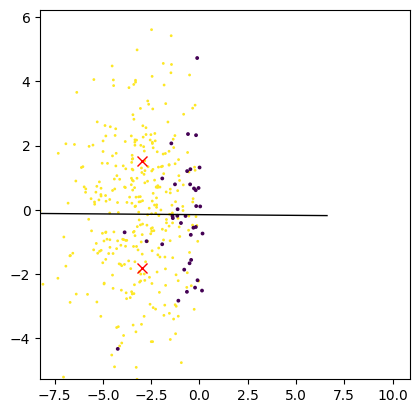

Printando o H[i][C] atual [[-3.84446605 -2.19012639]
 [-1.32374015  0.03302983]
 [-3.79912761  1.84971011]]
[-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]
axis_limits [-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]


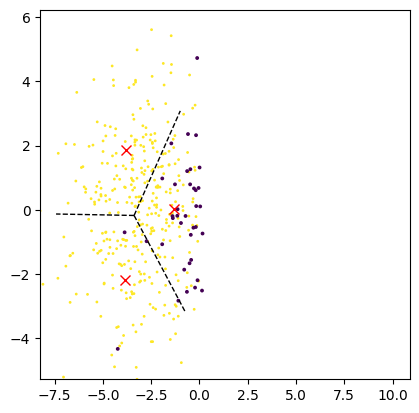

Printando o H[i][C] atual [[-1.32374015  0.03302983]]
[-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]
axis_limits [-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]


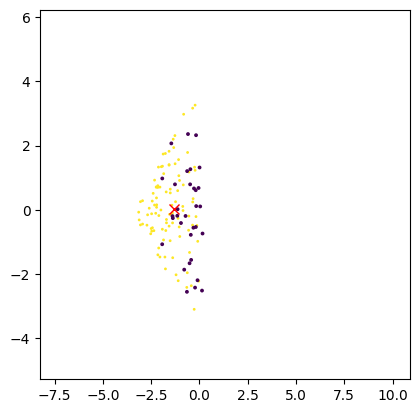

Printando o H[i][C] atual [[-1.14128988  1.2284547 ]
 [-1.44537367 -0.76392008]]
[-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]
axis_limits [-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]


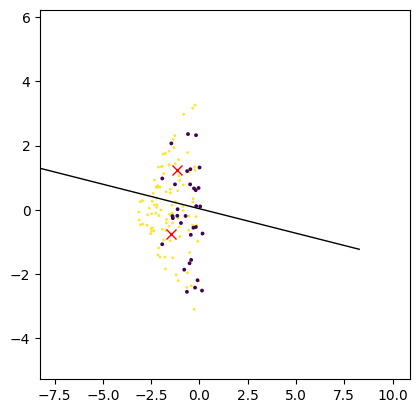

Printando o H[i][C] atual [[-1.97145399 -0.14985107]
 [-0.55012836 -1.50336775]
 [-0.92305508  1.38738065]]
[-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]
axis_limits [-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]


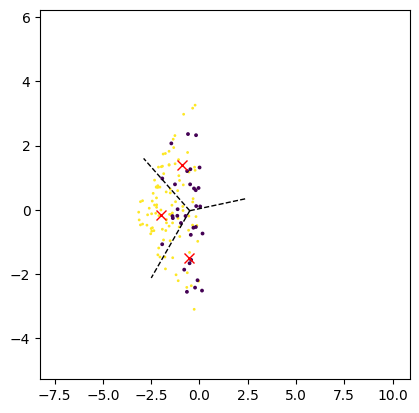

Printando o H[i][C] atual [[-0.6835287  -2.0653274 ]
 [-1.09989331  1.67550891]
 [-2.27422388 -0.18560542]
 [-0.73406273 -0.06552557]]
[-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]
axis_limits [-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]


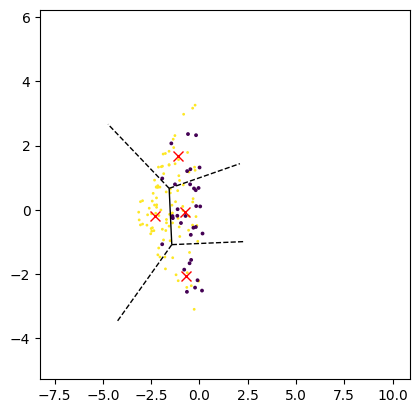

Printando o H[i][C] atual [[-0.85396084  0.14109093]]
[-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]
axis_limits [-8.246689060448395, 10.885891336546326, -5.276054965012157, 6.232671045470704]


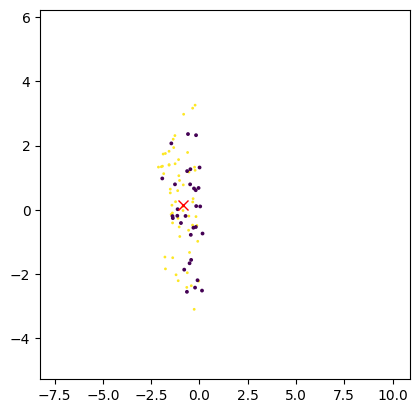

In [9]:
plot_space_segmentation_process(X,y,H, dm_case, "mvnrnd01.mat")

In [15]:
import imageio as imageio



In [16]:

def pdf_to_images(pdf_filename):
    from pdf2image import convert_from_path
    return convert_from_path(pdf_filename)

def create_gif_from_pdf(pdf_filename, gif_filename, duration=500):
    images = pdf_to_images(pdf_filename)
    imageio.mimsave(gif_filename, images, duration=duration)

# Usar a função
create_gif_from_pdf("multipage.pdf", "multipage.gif")
